In [127]:
"""
These receptive fields are derived from scale-space theory, specifically in the paper `Normative theory of visual receptive fields by Lindeberg, 2021 <https://www.sciencedirect.com/science/article/pii/S2405844021000025>`_.

For use in spiking / binary signals, see the paper on `Translation and Scale Invariance for Event-Based Object tracking by Pedersen et al., 2023 <https://dl.acm.org/doi/10.1145/3584954.3584996>`_
"""

from typing import List, Tuple, Union, Optional

import torch


def gaussian_kernel(x, s, c):
    """
    Efficiently creates a 2d gaussian kernel.

    Arguments:
      x (torch.Tensor): A 2-d matrix
      s (float): The variance of the gaussian
      c (torch.Tensor): A 2x2 covariance matrix describing the eccentricity of the gaussian
    """
    ci = torch.linalg.inv(c)
    cd = torch.linalg.det(c)
    fraction = 1 / (2 * torch.pi * s * torch.sqrt(cd))
    b = torch.einsum("bimj,jk->bik", -x.unsqueeze(2), ci)
    a = torch.einsum("bij,bij->bi", b, x)
    return fraction * torch.exp(a / (2 * s))


def spatial_receptive_field(
    angle, ratio, size: int, scale: float = 2.5, dx: int = 0, dy: int = 0, domain: float = 8
):
    """
    Creates a (size x size) receptive field kernel

    Arguments:
      angle (float): The rotation of the kernel in radians
      ratio (float): The eccentricity as a ratio
      size (int): The size of the square kernel in pixels
      scale (float): The scale of the field. Defaults to 2.5
      domain (float): The initial coordinates from which the field is sampled. Defaults to 8 (equal to -8 to 8).
    """
    sm = torch.ones(2)
    sm[0] = scale
    sm[1] = scale*ratio
    a = torch.linspace(-domain, domain, size)
    r = torch.ones((2,2))
    r[0][0] = angle.cos()
    r[0][1] = angle.sin()
    r[1][0] = -angle.sin()
    r[1][1] = angle.cos()    
    c = (r * sm) @ (sm * r).T
    xs, ys = torch.meshgrid(a, a, indexing="xy")
    coo = torch.stack([xs, ys], dim=2)
    k = gaussian_kernel(coo, scale, c)
    k = _derived_field(k, (dx, dy))
    return k / k.sum()


def _extract_derivatives(
    derivatives: Union[int, List[Tuple[int, int]]]
) -> Tuple[List[Tuple[int, int]], int]:
    if isinstance(derivatives, int):
        if derivatives == 0:
            return [(0, 0)], 0
        else:
            return [
                (x, y) for x in range(derivatives + 1) for y in range(derivatives + 1)
            ], derivatives
    elif isinstance(derivatives, list):
        return derivatives, max([max(x, y) for (x, y) in derivatives])
    else:
        raise ValueError(
            f"Derivatives expected either a number or a list of tuples, but got {derivatives}"
        )


def _derived_field(
    field: torch.Tensor, derivatives: Tuple[int, int]
) -> torch.Tensor:
    out = []
    (dx, dy) = derivatives
    if dx == 0:
        fx = field
    else:
        fx = field.diff(
            dim=0, prepend=torch.zeros(dx, field.shape[1]), n=dx)

    if dy == 0:
        fy = fx
    else:
        fy = fx.diff(
            dim=1, prepend=torch.zeros(field.shape[0], dy), n=dy)
    out.append(fy)
    return torch.concat(out)


def spatial_receptive_fields_with_derivatives(
    gf_attr,
    derivative_max: int,
    size: int,
    min_scale: float = 0.2,
    max_scale: float = 1.5,
    min_ratio: float = 0.2,
    max_ratio: float = 1,
) -> torch.Tensor:
    r"""
    Creates a number of receptive field with 1st directional derivatives.
    The parameters decide the number of combinations to scan over, i. e. the number of receptive fields to generate.
    Specifically, we generate ``derivatives * (n_angles * n_scales * (n_ratios - 1) + n_scales)`` fields.
    The ``(n_ratios - 1) + n_scales`` terms exist because at ``ratio = 1``, fields are perfectly symmetrical, and there
    is therefore no reason to scan over the angles and scales for ``ratio = 1``.
    However, ``n_scales`` receptive fields still need to be added (one for each scale-space).
    Finally, the ``derivatives *`` term comes from the addition of spatial derivatives.
    Arguments:
        n_scales (int): Number of scaling combinations (the size of the receptive field) drawn from a logarithmic distribution
        n_angles (int): Number of angular combinations (the orientation of the receptive field)
        n_ratios (int): Number of eccentricity combinations (how "flat" the receptive field is)
        size (int): The size of the square kernel in pixels
        derivatives (Union[int, List[Tuple[int, int]]]): The spatial derivatives to include. Defaults to 0 (no derivatives).
            Can either be a number, in which case 1 + 2 ** n derivatives will be made (except when 0, see below).
              Example: `derivatives=0` omits derivatives
              Example: `derivatives=1` provides 2 spatial derivatives + 1 without derivation
            Or a list of tuples specifying the derivatives in both spatial dimensions
              Example: `derivatives=[(0, 0), (1, 2)]` provides two outputs, one without derivation and one :math:`\partial_x \partial^2_y`
    """

    def _stack_empty(x):
        if len(x) == 0:
            return torch.tensor([])
        else:
            return torch.stack(x)

    # We add extra space in both the domain and size to account for the derivatives
    domain = 8 + derivative_max * size * 0.5

    rings = _stack_empty(
        [
            spatial_receptive_field(attr[1], attr[2], size=size + 2 * derivative_max, scale=attr[0], dx=attr[3], dy=attr[4], domain=domain)
            for attr in gf_attr
        ]
    )
    derived_fields = rings[
        :,
        derivative_max : size + derivative_max,
        derivative_max : size + derivative_max,  # Remove extra space
    ]
    #derived_fields.sum().backward()
    #print(angles.grad)
    return derived_fields




In [128]:
"""
These receptive fields are derived from scale-space theory, specifically in the paper `Normative theory of visual receptive fields by Lindeberg, 2021 <https://www.sciencedirect.com/science/article/pii/S2405844021000025>`_.

For use in spiking / binary signals, see the paper on `Translation and Scale Invariance for Event-Based Object tracking by Pedersen et al., 2023 <https://dl.acm.org/doi/10.1145/3584954.3584996>`_
"""

from typing import Callable, List, NamedTuple, Optional, Tuple, Type, Union

import torch

#from norse.torch.module.leaky_integrator_box import LIBoxCell, LIBoxParameters
from norse.torch.module.snn import SNNCell



class SpatialReceptiveField2d(torch.nn.Module):
    """Creates a spatial receptive field as 2-dimensional convolutions.
    The parameters decide the number of combinations to scan over, i. e. the number of receptive fields to generate.
    Specifically, we generate ``n_scales * n_angles * (n_ratios - 1) + n_scales`` output_channels with aggregation,
    and ``in_channels * (n_scales * n_angles * (n_ratios - 1) + n_scales)`` without aggregation.

    The ``(n_ratios - 1) + n_scales`` terms exist because at ``ratio = 1``, fields are perfectly symmetrical, and there
    is therefore no reason to scan over the angles and scales for ``ratio = 1``.
    However, ``n_scales`` receptive field still needs to be added (one for each scale-space).

    Parameters:
        n_scales (int): Number of scaling combinations (the size of the receptive field) drawn from a logarithmic distribution
        n_angles (int): Number of angular combinations (the orientation of the receptive field)
        n_ratios (int): Number of eccentricity combinations (how "flat" the receptive field is)
        size (int): The size of the square kernel in pixels
        derivatives (Union[int, List[Tuple[int, int]]]): The number of derivatives to use in the receptive field.
        aggregate (bool): If True, sums the input channels over all output channels. If False, every
        output channel is mapped to every input channel, which may blow up in complexity.
        **kwargs: Arguments passed on to the underlying torch.nn.Conv2d
    """

    def __init__(
        self,
        in_channels: int,
        n_scales: int,
        n_angles: int,
        n_ratios: int,
        size: int,
        derivatives: Union[int, List[Tuple[int, int]]] = 0,
        min_scale: float = 0.2,
        max_scale: float = 1.5,
        min_ratio: float = 0.2,
        max_ratio: float = 1,
        aggregate: bool = True,
        **kwargs
    ) -> None:
        super().__init__()

        self.aggregate = aggregate
        self.size = size
        self.derivatives = derivatives
        self.in_channels = in_channels
        self.kwargs = kwargs
        
        self.angles = torch.linspace(0, torch.pi - torch.pi / n_angles, n_angles, requires_grad=True)
        self.ratios = torch.linspace(min_ratio, max_ratio, n_ratios)
        self.log_scales = torch.linspace(min_scale, max_scale, n_scales)
        scales = torch.exp(self.log_scales)
        
        self.update = False
        derivative_list, derivative_max = _extract_derivatives(self.derivatives)
        gf_attr = [[s, a, r, d[0], d[1]] for s in scales for a in self.angles for r in self.ratios for d in derivative_list]
        self.gf_attr = torch.tensor(gf_attr, requires_grad=True)
        self.fields = spatial_receptive_fields_with_derivatives(
            gf_attr,
            derivative_max,
            size,
        )
        if self.aggregate:
            self.out_channels = self.fields.shape[0]
            weights = self.fields.unsqueeze(1).repeat(1, in_channels, 1, 1)
        else:
            self.out_channels = self.fields.shape[0] * in_channels
            empty_weights = torch.zeros(in_channels, self.fields.shape[0], size, size)
            weights = []
            for i in range(in_channels):
                in_weights = empty_weights.clone()
                in_weights[i] = self.fields
                weights.append(in_weights)
            weights = torch.concat(weights, 1).permute(1, 0, 2, 3)
        self.conv = torch.nn.Conv2d(in_channels, self.out_channels, size, **kwargs)
        self.conv.weight = torch.nn.Parameter(weights, requires_grad=False)
        self.conv.weight[:] = weights[:]
        print(self.gf_attr)
        print(self.angles, self.ratios, self.log_scales)

    def forward(self, x: torch.Tensor):
        if self.update:
            scales = torch.exp(self.log_scales)
            self.update = False
            self.fields = spatial_receptive_fields_with_derivatives(
                scales,
                self.angles,
                self.ratios,
                self.size,
                self.derivatives,
            )
            if self.aggregate:
                self.out_channels = self.fields.shape[0]
                weights = self.fields.unsqueeze(1).repeat(1, self.in_channels, 1, 1)
            else:
                self.out_channels = self.fields.shape[0] * self.in_channels
                empty_weights = torch.zeros(self.in_channels, self.fields.shape[0], self.size, self.size)
                weights = []
                for i in range(self.in_channels):
                    in_weights = empty_weights.clone()
                    in_weights[i] = self.fields
                    weights.append(in_weights)
                weights = torch.concat(weights, 1).permute(1, 0, 2, 3)
            self.conv = torch.nn.Conv2d(self.in_channels, self.out_channels, self.size, **self.kwargs)
            self.conv.weight = torch.nn.Parameter(weights, requires_grad=False)
            self.conv.weight[:] = weights[:]
        
        return self.conv(x)



def diff(model, lr = 0.01):
    with torch.no_grad():
        model.angles += model.angles.grad*lr
        model.ratios += model.ratios.grad*lr
        model.log_scales += model.log_scales.grad*lr
    model.angles.grad.zero_()
    model.log_scales.grad.zero_()
    model.ratios.grad.zero_()
    model.update = True


In [129]:
import time
import matplotlib.pyplot as plt

# #print(rf.shape)
# for a in rf.conv.weight:
#     #plt.figure()
#     plt.imshow(a[0].detach().numpy())

rf = SpatialReceptiveField2d(1, 1, 1, 2, 9)
loss = torch.nn.MSELoss()
optimizer = True
target = spatial_receptive_field(torch.tensor(1.), torch.tensor(.2), torch.tensor(9), torch.tensor(2.5))
inp = torch.ones((1, 9,9))

for i in range(200):

    start = time.time()
    out = rf(inp)
    end = time.time() - start
    l = loss(target, sum(sum(out)))
    l.backward()
    print(rf.gf_attr, "\n", rf.gf_attr.grad)
    diff(rf, 1e7)
    
print(rf.angles, rf.log_scales, rf.ratios)

tensor([[1.2214, 0.0000, 0.2000, 0.0000, 0.0000],
        [1.2214, 0.0000, 1.0000, 0.0000, 0.0000]], requires_grad=True)
tensor([0.], requires_grad=True) tensor([0.2000, 1.0000]) tensor([0.2000])
tensor([[1.2214, 0.0000, 0.2000, 0.0000, 0.0000],
        [1.2214, 0.0000, 1.0000, 0.0000, 0.0000]], requires_grad=True) 
 None


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [ ]:
print((sum(out[:]).detach().numpy()))
for i in rf.conv.weight:
    plt.figure()
    plt.imshow(((i[0].detach().numpy())))

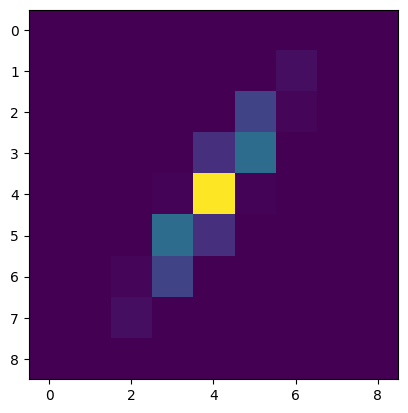

In [241]:
plt.imshow(target)

In [223]:
Q.sum().backward()

In [137]:
print(a.grad, b.grad)

None tensor([-12.,  -8.])


r grad: tensor([[ 2.3669e-04, -1.7095e-05],
        [ 1.6632e-01, -3.8603e-03]])
angle grad: None
ratio grad: None
scale grad: tensor(-0.0365)


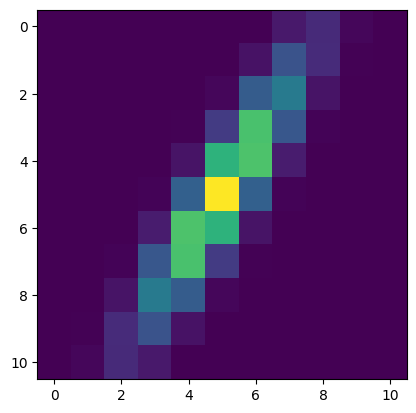

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
def gaussian_kernel(x, s, c):
    """
    Efficiently creates a 2d gaussian kernel.

    Arguments:
      x (torch.Tensor): A 2-d matrix
      s (float): The variance of the gaussian
      c (torch.Tensor): A 2x2 covariance matrix describing the eccentricity of the gaussian
    """
    ci = torch.linalg.inv(c)
    cd = torch.linalg.det(c)
    fraction = 1 / (2 * torch.pi * s * torch.sqrt(cd))
    b = torch.einsum("bimj,jk->bik", -x.unsqueeze(2), ci)
    a = torch.einsum("bij,bij->bi", b, x)
    return fraction * torch.exp(a / (2 * s))

s = torch.tensor(2., requires_grad=True)
ratio = torch.tensor(.2, requires_grad=True)
sm = torch.tensor([s, s * ratio], requires_grad=True)
x = torch.linspace(-5, 5, 11)
x = torch.unsqueeze(x, 0).repeat(11, 1)
x = torch.stack((x, x.T))
x = torch.einsum("abc->bca",x)
angle = torch.tensor(np.pi/3, requires_grad=True)
r = torch.tensor(
    [[torch.cos(angle), torch.sin(angle)], [-torch.sin(angle), torch.cos(angle)]],
    dtype=torch.float32, requires_grad=True
)

c = (r * sm) @ (sm * r).T

a = gaussian_kernel(x, s, c)
plt.imshow(a.detach().numpy())
a.sum().backward()

print("r grad:", r.grad)
print("angle grad:", angle.grad)
print("ratio grad:", ratio.grad)
print("scale grad:", s.grad)


In [9]:
print(c.grad_fn)

In [20]:
angle = torch.tensor(np.pi/3, requires_grad=True)
r = torch.tensor([[torch.cos(angle), torch.sin(angle)], [-torch.sin(angle), torch.cos(angle)]], dtype=torch.float32, requires_grad=True)

r.sum().backward()
print(angle.grad)

None


In [39]:
angle = torch.tensor(np.pi/3, requires_grad=True)
b=torch.tensor([torch.sin(angle)], dtype=torch.float32, requires_grad=True)
b.sum().backward()
print(b.grad)
print(angle.grad)

tensor([1.])
None


In [116]:
import torch
import numpy as np

angle = torch.tensor(np.pi/3, requires_grad=True)
b = torch.tensor([angle.sin()], dtype=torch.float32)

# Use the in-place sin_ operation
b.sin_()

print("Is angle a leaf variable?", angle.is_leaf)  # True
print("Is b a leaf variable?", b.is_leaf)          # False


Is angle a leaf variable? True
Is b a leaf variable? True


In [122]:
angle = torch.tensor([np.pi/3, 1], requires_grad=True)
ratio = torch.tensor([np.pi/3, 1], requires_grad=True)
scale = torch.tensor([np.pi/3, 1], requires_grad=True)

In [125]:
spatial_receptive_fields_with_derivatives(scale, angle, ratio, 5)

tensor([-5.2705e-11, -3.0393e-12])


In [12]:







### Method 2

"""
These receptive fields are derived from scale-space theory, specifically in the paper `Normative theory of visual receptive fields by Lindeberg, 2021 <https://www.sciencedirect.com/science/article/pii/S2405844021000025>`_.

For use in spiking / binary signals, see the paper on `Translation and Scale Invariance for Event-Based Object tracking by Pedersen et al., 2023 <https://dl.acm.org/doi/10.1145/3584954.3584996>`_
"""

from typing import Callable, List, NamedTuple, Optional, Tuple, Type, Union

import torch

#from norse.torch.module.leaky_integrator_box import LIBoxCell, LIBoxParameters
from norse.torch.module.snn import SNNCell



class SpatialReceptiveField2d(torch.nn.Module):
    """Creates a spatial receptive field as 2-dimensional convolutions.
    The parameters decide the number of combinations to scan over, i. e. the number of receptive fields to generate.
    Specifically, we generate ``n_scales * n_angles * (n_ratios - 1) + n_scales`` output_channels with aggregation,
    and ``in_channels * (n_scales * n_angles * (n_ratios - 1) + n_scales)`` without aggregation.

    The ``(n_ratios - 1) + n_scales`` terms exist because at ``ratio = 1``, fields are perfectly symmetrical, and there
    is therefore no reason to scan over the angles and scales for ``ratio = 1``.
    However, ``n_scales`` receptive field still needs to be added (one for each scale-space).

    Parameters:
        n_scales (int): Number of scaling combinations (the size of the receptive field) drawn from a logarithmic distribution
        n_angles (int): Number of angular combinations (the orientation of the receptive field)
        n_ratios (int): Number of eccentricity combinations (how "flat" the receptive field is)
        size (int): The size of the square kernel in pixels
        derivatives (Union[int, List[Tuple[int, int]]]): The number of derivatives to use in the receptive field.
        aggregate (bool): If True, sums the input channels over all output channels. If False, every
        output channel is mapped to every input channel, which may blow up in complexity.
        **kwargs: Arguments passed on to the underlying torch.nn.Conv2d
    """

    def __init__(
        self,
        in_channels: int,
        n_scales: int,
        n_angles: int,
        n_ratios: int,
        size: int,
        derivatives: Union[int, List[Tuple[int, int]]] = 0,
        min_scale: float = 0.2,
        max_scale: float = 1.5,
        min_ratio: float = 0.2,
        max_ratio: float = 1,
        aggregate: bool = True,
        **kwargs
    ) -> None:
        super().__init__()
        
        self.angles = torch.linspace(0, torch.pi - torch.pi / n_angles, n_angles, requires_grad=True)
        self.ratios = torch.linspace(min_ratio, max_ratio, n_ratios, requires_grad=True)
        self.log_scales = torch.linspace(min_scale, max_scale, n_scales, requires_grad=True)
        self.scales = torch.exp(self.log_scales)
        self.size = size
        self.derivatives = derivatives
        self.min_scale = min_scale
        self.max_scale = max_scale 
        self.min_ratio = min_ratio
        self.max_ratio = max_ratio
        self.aggregate = aggregate
        self.in_channels = in_channels
        self.kwargs = kwargs 

        

    def forward(self, x: torch.Tensor):
        fields = spatial_receptive_fields_with_derivatives(
            self.scales,
            self.angles,
            self.ratios,
            self.size,
            self.derivatives,
            self.min_scale,
            self.max_scale,
            self.min_ratio,
            self.max_ratio,
            **self.kwargs
        )
        if self.aggregate:
            self.out_channels = fields.shape[0]
            weights = fields.unsqueeze(1).repeat(1, self.in_channels, 1, 1)
        else:
            self.out_channels = fields.shape[0] * in_channels
            empty_weights = torch.zeros(in_channels, fields.shape[0], self.size, self.size)
            weights = []
            for i in range(in_channels):
                in_weights = empty_weights.clone()
                in_weights[i] = fields
                weights.append(in_weights)
            weights = torch.concat(weights, 1).permute(1, 0, 2, 3)
        self.conv = torch.nn.Conv2d(self.in_channels, self.out_channels, self.size, **self.kwargs)
        self.conv.weight = torch.nn.Parameter(weights, requires_grad=False)
        self.conv.weight[:] = weights[:]
        return self.conv(x)


###